Seasonal and daily changes in air temperature closely follow the sinusoidal patterns of solar radiation. So, for a given location, there is a strong relationship between air temperature and the day of the calendar year and the hour of the day. As a result, air temperature also exhibits a strong autocorrelation, which means that the air tempearature today is similar to the air temperature yesterday or tomorrow. In this exercise we will inspect the dynamics of daily minimum (TMIN) and maximum (TMAX) air temperatures. We will calculate average TMAX and TMIN for each day of the year and we will also fit a simple sinusoidal model and examine its residuals.


In [40]:
# Compute normal distribution parameters
T_amplitude_mean = T_amplitude.mean()
T_amplitude_std = T_amplitude.std()

print(round(T_amplitude_mean,1), 'Celsius')
print(round(T_amplitude_std,1), 'Celsius')

12.9 Celsius
4.7 Celsius


## Autocorrelation: Pandas version

The code in the previous cell uses simple concepts like lambda functions and for loops to solve the problem together with the `pearsonr` function of the SciPy module. A more compact version could be written by leveraging the Pandas built-in `autocorr()` function (which uses SciPy under the hood, so the result should be nearly identical if we coded things right)

In [168]:
r, lags = [], []
for k,w in enumerate(range(1,30)):
    r.append(df['avg_co2'].autocorr(w))
    lags.append(w)


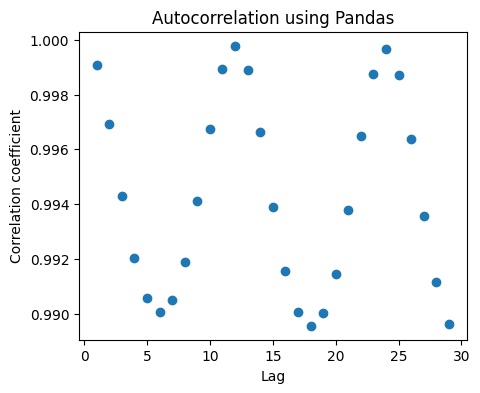

In [169]:
# Visualize the correlation coefficient for multiple lags
plt.figure(figsize=(5,4))
plt.title('Autocorrelation using Pandas')
plt.scatter(lags, r)
plt.xlabel('Lag')
plt.ylabel('Correlation coefficient')
plt.show()


## Examine residuals

Residuals tmax: Mean= -0.019181784247878537 Std: 5.414114625572652
Residuals tmin: Mean= -0.0027578743096251766 Std: 4.879320798713006


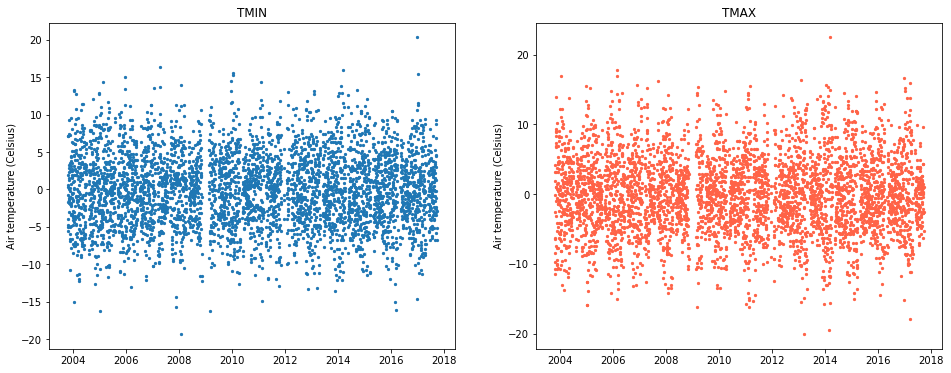

In [41]:

mean_tmax = df["T_DAILY_MAX"].rolling(window=30, center=True).mean()
mean_tmin = df["T_DAILY_MIN"].rolling(window=30, center=True).mean()

residuals_tmax = mean_tmax - df["T_DAILY_MAX"]
residuals_tmin = mean_tmin - df["T_DAILY_MIN"]

print("Residuals tmax: Mean=",residuals_tmax.mean(), "Std:",residuals_tmax.std())
print("Residuals tmin: Mean=",residuals_tmin.mean(), "Std:",residuals_tmin.std())

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(df["LST_DATE"],residuals_tmin, s=5)
plt.title('TMIN')
plt.ylabel("Air temperature (Celsius)")

plt.subplot(1,2,2)
plt.scatter(df["LST_DATE"],residuals_tmax, s=5, color='tomato')
plt.title('TMAX')
plt.ylabel("Air temperature (Celsius)")

plt.show()

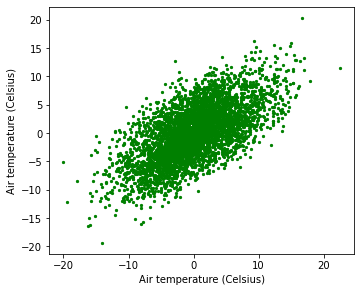

In [54]:
# Investigate correlation of residuals of TMIN and TMAX
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.scatter(residuals_tmax, residuals_tmin, s=5, color='green')
plt.xlabel("Air temperature (Celsius)")
plt.ylabel("Air temperature (Celsius)")
plt.show()


## Compute Tmax and Tmin for each DOY

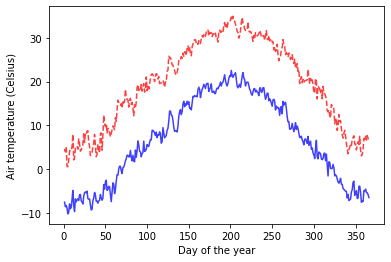

In [65]:
# Generate smooth
df_grouped = df.groupby(["DOY"]).mean()

plt.plot(df_grouped.index, df_grouped["T_DAILY_MIN"], '-b',  alpha=0.75, label='TMIN')
plt.plot(df_grouped.index, df_grouped["T_DAILY_MAX"], '--r', alpha=0.75, label='TMAX')
plt.xlabel('Day of the year')
plt.ylabel("Air temperature (Celsius)")
plt.show()


In [46]:
# Occurrence of maximum values (on average)
print(df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().idxmax())
print(df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().idxmax())


199
199


In [47]:
# Occurrence of minimum values (on average)
print(df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().idxmin())
print(df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().idxmin())


8
8


## Compute annual thermal amplitude

To compute the amplitude we will first smooth the air temperature signal using a centered moving average. THen we have two options, computing the amplitude from records of 
Here there are two options: 1) computing the amplitude using a smoothed version of Tmin and Tmax, or 2) simply computing the average amplitude of each day on record. Let's try both and see if there is any difference. We should favor the easiest approach.


For the first approach, we will estimate the annual average thermal amplitude by first computing the amplitude for each day of the year, and then calculate the annual average. This approach removes some noise before calcualting the amplitude.


In [48]:
# Compute Tmax average amplitude by using de-noised signal
T_max_max = df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().max()
T_max_min = df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().min()
T_max_amplitude = ((T_max_max - T_max_min)/2)
print(T_max_amplitude)


14.834194139194146


In [49]:
# Compute Tmin average amplitude by using de-noised signal 
T_min_max = df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().max()
T_min_min = df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().min()
T_min_amplitude = ((T_min_max - T_min_min)/2)
print(T_min_amplitude)


14.545347985347988


The amplitude of Tmax and Tmin are remarkably similar, which means that we can probably take advantage of this fact to model air temperature using the same amplitude parameter.

## Build model for air temperature

A sinusoidal model is probably adequate to mimic the seasonal dynamics. This is the deterministic part of our model. The difference between our model and observations we will be attributed to random noise, or to more complicated relationships that go beyond the scope of this exercise.

$$ T(t) = T_{avg} + A \; sin \Bigg[2 \pi (\frac{DOY}{365} + \phi + \frac{\pi}{2}) \Bigg] + \epsilon $$


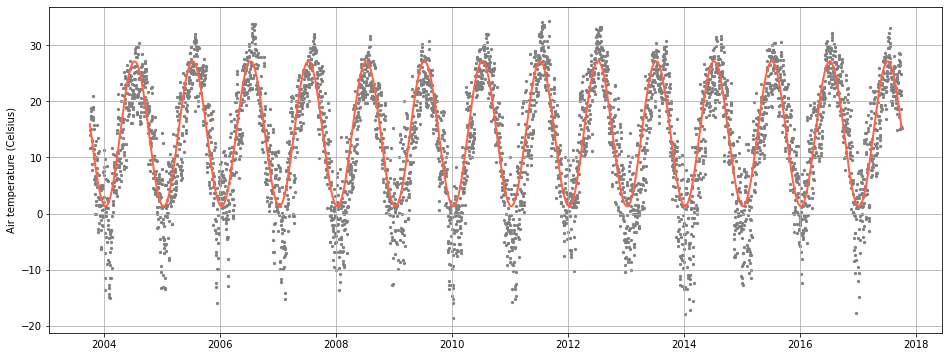

In [82]:
# Get amplitude of the sinusoidal pattern
dates = df["LST_DATE"]

# Get day of the year for each input date
doy = df["LST_DATE"].dt.dayofyear

# Set model parameters based on our previous findings
T_avg = 14.2
A = 12.9
phase = 8
T_pred = T_avg + A * np.sin(2*np.pi*( (doy-phase)/365) - np.pi/2)

plt.figure(figsize=(16,6))
plt.scatter(df["LST_DATE"], df["T_DAILY_AVG"], s=5, color='gray', label="Observed TAVG")
plt.plot(dates,T_pred, label="Predicted TAVG", color='tomato', linewidth=2)
plt.ylabel("Air temperature (Celsius)")
plt.grid()
plt.show()

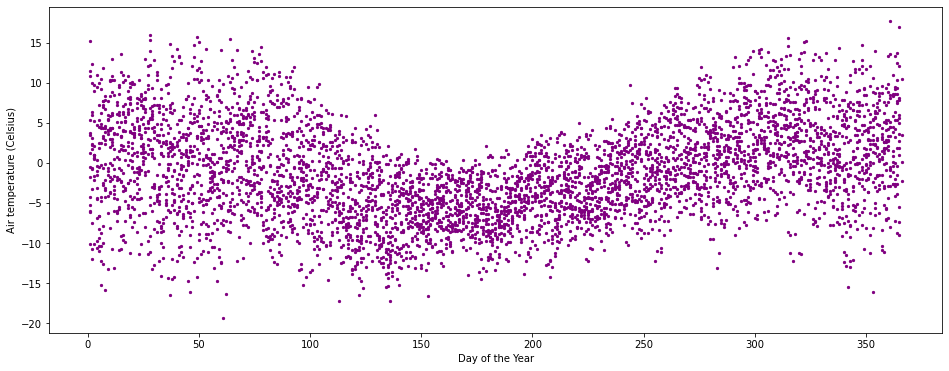

Mean absolute error: 4.9 Celsius


In [81]:
# Compute residuals between observed and predicted
TAVG_residuals = df["T_DAILY_AVG"] - T_pred
plt.figure(figsize=(16,6))
plt.scatter(doy,TAVG_residuals, s=5, color='purple')
plt.xlabel('Day of the Year')
plt.ylabel("Air temperature (Celsius)")
plt.show()

# Compute mean absolute error
MAE = np.mean(np.abs(TAVG_residuals)) 

# Object-oriented computation
#MAE = TAVG_residuals.abs().mean()
print('Mean absolute error:', round(MAE,1) ,'Celsius')

Our model does a reasonable job prdicting air temperature with an error of 4 degrees Celsius. Depending on the application the magnitude of the error may be acceptable or unacceptable. Clearly our model struggles to compute accurate daily average temperature values during the winter, spring, and fall seasons and is also not capturing the year-to-year variability. The model parameters were not optimed in this case, but rather estiamted from local observations. 


## Practice

- What mean absolute error do you obtain if the amplitude is increased by 3 degrees Celsius in an attempt to better capture low temperatures?

- What modifications would you implement to reduce the error during winter, fall, and spring seasons?